In [1]:
import matplotlib.pyplot as plt

from oxeo.water.datamodules.datasets import VirtualDataset
from oxeo.water.datamodules import ConstellationDataModule
from oxeo.water.datamodules import transforms as oxtransforms
from torchvision.transforms import Compose
from satools.io import ConstellationData,constellation_dataarray,create_index_map
from satools.io import constellation_dataarray, constellations_dataset, load_virtual_datasets

from satextractor.models import constellation_info

In [2]:
list(constellation_info.SENTINEL2_BAND_INFO.keys())

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B8A',
 'B09',
 'B10',
 'B11',
 'B12']

In [3]:
import dask.array as da
import numpy as np
import xarray as xr

In [4]:
paths = [
        'oxeo-water/prod/43_P_10000_63_131',
        'oxeo-water/prod/43_P_10000_63_132',
         'oxeo-water/prod/43_P_10000_64_131',
         'oxeo-water/prod/43_P_10000_64_132',
        ]

constellations = ['sentinel-2']
all_paths = {kk:[f"gs://{path}" for path in paths] for kk in constellations}



data_sen2 = ConstellationData("sentinel-2",bands=list(constellation_info.SENTINEL2_BAND_INFO.keys()),
                             paths=all_paths["sentinel-2"],
                             height=1000,
                             width=1000)


data_labels = ConstellationData("sentinel-2",bands=["pekel"],
                             paths=all_paths["sentinel-2"],
                             height=1000,
                             width=1000)

In [5]:
import pandas as pd


#train_index_map = create_index_map(train_constellation_regions, date_range=("2015-01-01","2017-01-01"), 
#                                   patch_size=patch_size, output="train_index_map.csv")

#val_index_map = create_index_map(val_constellation_regions, date_range=("2017-01-01","2018-01-01"), 
#                                   patch_size=patch_size, output = "val_index_map.csv")

train_index_map = pd.read_csv('/home/fran/repos/oxeo-water/notebooks/train_index_map.csv', header=None).values
val_index_map = pd.read_csv('/home/fran/repos/oxeo-water/notebooks/val_index_map.csv', header=None).values

In [6]:
patch_size = 512

train_constellation_regions={"data":[[data_sen2]],"label":[[data_labels]]}
val_constellation_regions={"data":[[data_sen2]],"label":[[data_labels]]}


In [7]:
dm = ConstellationDataModule(train_constellation_regions=train_constellation_regions,
                             val_constellation_regions=val_constellation_regions, 
                             patch_size=512, 
                             train_index_map=train_index_map,
                             val_index_map=val_index_map,
                             preprocess=Compose([oxtransforms.SelectConstellation("sentinel-2"),
                                                 oxtransforms.SelectBands(["B04","B03","B02"]),
                                                 oxtransforms.Compute()]),
                             transforms=None,
                             batch_size=16,
                             num_workers=8)

dm.setup()

In [8]:
dl = iter(dm.train_dataloader())

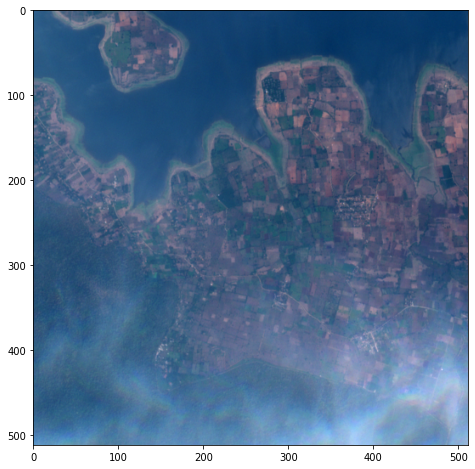

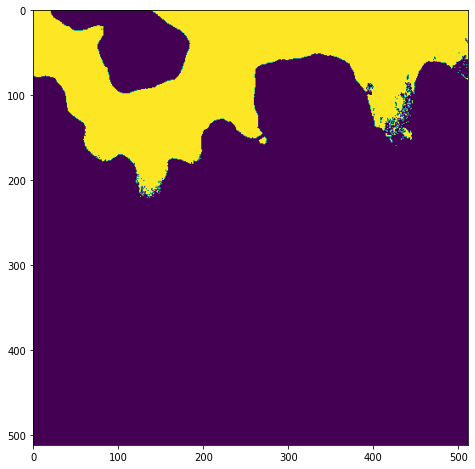

In [18]:
from skimage.exposure import rescale_intensity

arr = next(dl)

img = arr["data"][2].numpy().transpose(1,2,0)
img =rescale_intensity(img,out_range=float)

plt.figure(figsize=(8,8))

plt.imshow(img)
plt.show()
plt.figure(figsize=(8,8))
plt.imshow((arr["label"][2,0]))
plt.show()

